

# Comme le projet est assez long, il y a peu de commentaire le long du script. La synthèse des résultats et les conclusions sont tous résumés à la fin.




# **Librairies**

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math as math

def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn


# **Mount Google Drive (required for google colab users only !)**

Si vous utilisez Google Colab, 
Merci de copier les données dans le répertoire : 
My Drive/Colab Notebooks/Openclassroom/

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

import os

dir = "/content/drive/My Drive/Colab Notebooks/Openclassroom/"
os.chdir(dir)

#!ls


Mounted at /content/drive/


# **Load data**

In [3]:
train = pd.read_csv('train.csv')

# le fichier test n'est pas requis ici, puisque nous avons besin des étiquettes pour vérifier les performances
#test = pd.read_csv('test.csv')

print(train.head())


   id                species   margin1  ...  texture62  texture63  texture64
0   1            Acer_Opalus  0.007812  ...   0.004883   0.000000   0.025391
1   2  Pterocarya_Stenoptera  0.005859  ...   0.000977   0.039062   0.022461
2   3   Quercus_Hartwissiana  0.005859  ...   0.000000   0.020508   0.002930
3   5        Tilia_Tomentosa  0.000000  ...   0.017578   0.000000   0.047852
4   6     Quercus_Variabilis  0.005859  ...   0.000000   0.000000   0.031250

[5 rows x 194 columns]


# **Data preparation**

In [4]:
# Swiss army knife function to organize the data

from sklearn.preprocessing import LabelEncoder

def encode(train):
    le = LabelEncoder().fit(train.species) 
    labels = le.transform(train.species)           # encode species strings
    classes = list(le.classes_)                    # save column names for submission
    
    train = train.drop(['species', 'id'], axis=1)  
    
    return train, labels, classes

train, labels, classes = encode(train)

print(train.head(1))
print(labels[1:6])
print(classes[1:6])

    margin1   margin2   margin3  ...  texture62  texture63  texture64
0  0.007812  0.023438  0.023438  ...   0.004883        0.0   0.025391

[1 rows x 192 columns]
[49 65 94 84 40]
['Acer_Circinatum', 'Acer_Mono', 'Acer_Opalus', 'Acer_Palmatum', 'Acer_Pictum']


## Stratified Train/Test Split

Stratification is necessary for this dataset because there is a relatively large number of classes (100 classes for 990 samples). This will ensure we have all classes represented in both the train and test indices. 

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.2, random_state=42, stratify=labels)

# **Features Scaling**

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

========================================================================================================================

# K-Nearest Neighbors (Baseline model)

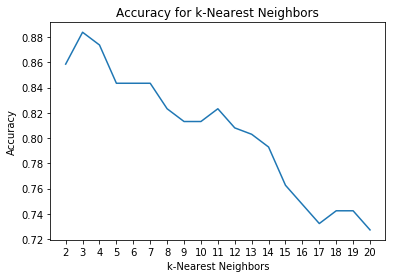

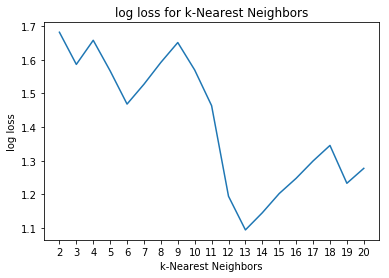

In [7]:
#import required packages
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

n = np.arange(2,21)

knn_acc_val = [] #to store acc_val values for different k
knn_ll_val = []

for K in n:
    model = KNeighborsClassifier(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    train_predictions = model.predict(X_test)
    knn_acc = accuracy_score(y_test, train_predictions)
    knn_acc_val.append(knn_acc) #store acc_val values
    train_predictions = model.predict_proba(X_test)
    knn_ll = log_loss(y_test, train_predictions)
    knn_ll_val.append(knn_ll)
    

#plotting the performance values against k values
plt.figure()
plt.plot(n, knn_acc_val)
plt.xticks(n)
plt.xlabel('k-Nearest Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy for k-Nearest Neighbors')
plt.show()

plt.figure()
plt.plot(n, knn_ll_val)
plt.xticks(n)
plt.xlabel('k-Nearest Neighbors')
plt.ylabel('log loss')
plt.title('log loss for k-Nearest Neighbors')
plt.show()


# **Find best K and recompute the model**

In [8]:
bestK = np.argmax(knn_acc_val) + np.min(n)

model = KNeighborsClassifier(n_neighbors = bestK)
model.fit(X_train, y_train)  #fit the model
train_predictions = model.predict(X_test) #make prediction on test set
knn_acc = accuracy_score(y_test, train_predictions)
train_predictions = model.predict_proba(X_test)
knn_ll = log_loss(y_test, train_predictions)


print("="*30)
print("KNeighborsClassifier (Baseline)")
print('Best k: ' , bestK)
print('accuracy score: ', knn_acc)
print('log loss: ', knn_ll)
print("="*30)


KNeighborsClassifier (Baseline)
Best k:  3
accuracy score:  0.8838383838383839
log loss:  1.5863413946913407


# **Plot average ROC curve for multiclass problem**

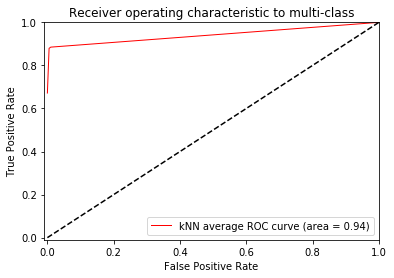

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

classes = np.unique(y_test)
n_classes = np.shape(y_test)
y_score = model.predict(X_test) #make prediction on test set


# Compute ROC curve and ROC area for each class
knn_fpr = dict()
knn_tpr = dict()
knn_roc_auc = dict()

for i in classes:
    y_test_log = y_test == i
    y_test_log = y_test_log*1
    y_score_log = y_score == i
    y_score_log = y_score_log*1
    
    knn_fpr[i], knn_tpr[i], _ = roc_curve(y_test_log, y_score_log)
    knn_roc_auc[i] = auc(knn_fpr[i], knn_tpr[i])

    
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
knn_all_fpr = np.concatenate([knn_fpr[i] for i in classes])

# Then interpolate all ROC curves at this points
knn_mean_tpr = np.zeros_like(knn_all_fpr)
for i in classes:
    knn_mean_tpr += np.interp(knn_all_fpr, knn_fpr[i], knn_tpr[i])

# Finally average it and compute AUC
knn_mean_tpr /= len(classes)

idx = np.argsort(knn_all_fpr)
knn_all_fpr = knn_all_fpr[idx]
knn_mean_tpr = knn_mean_tpr[idx]

knn_fpr["macro"] = knn_all_fpr
knn_tpr["macro"] = knn_mean_tpr
knn_roc_auc["macro"] = auc(knn_fpr["macro"], knn_tpr["macro"])

# Plot multiclass ROC curves
plt.figure()
plt.plot(knn_fpr["macro"], knn_tpr["macro"],
         label='kNN average ROC curve (area = {0:0.2f})'
               ''.format(knn_roc_auc["macro"]),
         color='red', linewidth=1) 

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

    
    
    
    ==================================================================================================================
    

# **Support Vector Machine**

# **Hyperparameter tuning using grid search and cross validation**

In [0]:
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': np.logspace(-3, 3, 10)},
                    {'kernel': ['linear'], 'C': np.logspace(-3, 3, 10)}]

# **Training SVM model using radial kernel**

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train, y_train)



GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': array([1.00000000e-03, 4.64158883e...
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                          'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
                         {'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                          'kernel': ['linear']}],
             pre_dispatch='2*n_

# **Accuracy Score**

In [12]:
train_predictions = svm_model.predict(X_test) #make prediction on test set
svm_acc = accuracy_score(y_test, train_predictions)

print("="*30)
print("SVM Classifier")

print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

print('accuracy score: ', svm_acc)

print("="*30)

SVM Classifier
Best C: 215.44346900318823 

Best Kernel: linear 

Best Gamma: auto_deprecated 

accuracy score:  0.9696969696969697


# **Confusion matrix**

In [13]:
train_predictions = svm_model.predict(X_test) #make prediction on train set
print(confusion_matrix(y_test, train_predictions))
print("\n")
print(classification_report(y_test, train_predictions))

train_predictions = svm_model.predict(X_train) #make prediction on train set
print("Training set score for SVM: %f" % svm_model.score(X_train, train_predictions))
print("Testing  set score for SVM: %f" % svm_model.score(X_test, y_test))

[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       0.67      1.00      0.80         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       0.00      0.00      0.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15 

# **Plot ROC curves for multiclass problem**

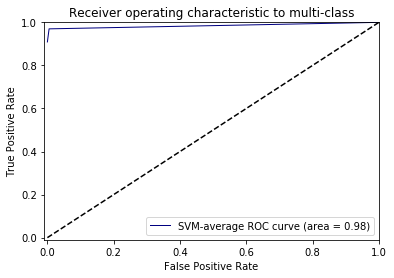

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

classes = np.unique(y_test)
n_classes = np.shape(y_test)
y_score = svm_model.predict(X_test) #make prediction on test set


# Compute ROC curve and ROC area for each class
svm_fpr = dict()
svm_tpr = dict()
svm_roc_auc = dict()

for i in classes:
    y_test_log = y_test == i
    y_test_log = y_test_log*1
    y_score_log = y_score == i
    y_score_log = y_score_log*1
    
    svm_fpr[i], svm_tpr[i], _ = roc_curve(y_test_log, y_score_log)
    svm_roc_auc[i] = auc(svm_fpr[i], svm_tpr[i])


# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
svm_all_fpr = np.concatenate([svm_fpr[i] for i in classes])

# Then interpolate all ROC curves at this points
svm_mean_tpr = np.zeros_like(svm_all_fpr)
for i in classes:
    svm_mean_tpr += np.interp(svm_all_fpr, svm_fpr[i], svm_tpr[i])

# Finally average it and compute AUC
svm_mean_tpr /= len(classes)

idx = np.argsort(svm_all_fpr)
svm_all_fpr = svm_all_fpr[idx]
svm_mean_tpr = svm_mean_tpr[idx]

svm_fpr["macro"] = svm_all_fpr
svm_tpr["macro"] = svm_mean_tpr
svm_roc_auc["macro"] = auc(svm_fpr["macro"], svm_tpr["macro"])

# Plot multiclass ROC curves
plt.figure()
plt.plot(svm_fpr["macro"], svm_tpr["macro"],
         label='SVM-average ROC curve (area = {0:0.2f})'
               ''.format(svm_roc_auc["macro"]),
         color='navy', linewidth=1)  

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()



# **Synthèse des résultats**

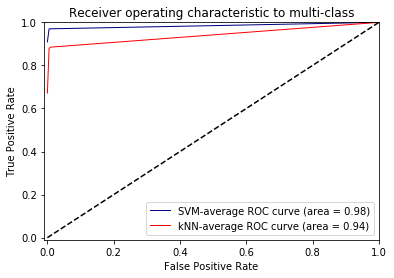

In [15]:
# Plot multiclass ROC curves
plt.figure()
plt.plot(svm_fpr["macro"], svm_tpr["macro"],
         label='SVM-average ROC curve (area = {0:0.2f})'
               ''.format(svm_roc_auc["macro"]),
         color='navy', linewidth=1)  
plt.plot(knn_fpr["macro"], knn_tpr["macro"],
         label='kNN-average ROC curve (area = {0:0.2f})'
               ''.format(knn_roc_auc["macro"]),
         color='red', linewidth=1)  

plt.plot([0, 1], [0, 1], 'k--') #, lw=lw)
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [16]:
print("="*30)
print("KNeighborsClassifier (Baseline)")
print('Best k: ' , bestK)
print('accuracy score: ', knn_acc)
print('AUC score: ', knn_roc_auc["macro"])
print('log loss: ', knn_ll)
print("="*30)
      
print("="*30)
print("SVM Classifier")

print('Best C:',svm_model.best_estimator_.C) 
print('Best Kernel:',svm_model.best_estimator_.kernel)
print('Best Gamma:',svm_model.best_estimator_.gamma)

print('accuracy score: ', svm_acc)
print('AUC score: ', svm_roc_auc["macro"])

print("="*30)



KNeighborsClassifier (Baseline)
Best k:  3
accuracy score:  0.8838383838383839
AUC score:  0.9413265306122448
log loss:  1.5863413946913407
SVM Classifier
Best C: 215.44346900318823
Best Kernel: linear
Best Gamma: auto_deprecated
accuracy score:  0.9696969696969697
AUC score:  0.9846938775510206


# **Conclusion**

Dans ce court projet, nous avons chargé un jeu de donnée caractérisant des feuilles d'arbre, splité par stratification et normalisé les variables. Puis nous avons entrainné un modèle kNN sur plusieurs valeurs de k. La meilleure prédiction a été trouvée pour k = 3 avec une précision de 88.38% et une AUC de 0.94. Ce modèle sert de baseline pour démontrer une amélioration de notre modèle suivant. Ce second modèle est basé sur un support vector machine. Plusieurs critères ont été étudiés par utilisation de la fonction GridSearchCV. Les meilleurs paramètres retenus sont C=215.44, Kernel=linear, Gamma=auto_deprecated. Il montre une précision de 96,96% et une
AUC de 0.98. Le modèle en SVM multiclasse est donc meilleur pour prédire la classe des feuilles étudiées.